## Raw text to word embeddings

### Preprocessing the labels of the raw imdb data

In [1]:
import os
imdb_dir = 'D:/Projects/keras/Deep Learning for text/aclImdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [2]:
labels = []
texts = []

In [3]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [1]:
# texts[100]

## Tokenizing the text of raw IMDB data

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                     # cut off reviews after 100 words
training_samples = 16472         # train on 16472 samples
validation_samples = 10000       # validate on 10000 samples
max_words = 10000                # consider only top 10000 words from the dataset


Using TensorFlow backend.


ImportError: No module named tensorflow

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
print(sequences[0])

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.'%len(word_index))

In [32]:
# display first 10 elements 
for x in list(word_index)[0:10]:
    print('key->',x, 'value ->', word_index[x])

key-> the value -> 1
key-> and value -> 2
key-> a value -> 3
key-> of value -> 4
key-> to value -> 5
key-> is value -> 6
key-> br value -> 7
key-> in value -> 8
key-> it value -> 9
key-> i value -> 10


In [16]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensors:', data.shape)
print('Shape of label tensors:', labels.shape)


Shape of data tensors: (26472, 100)
Shape of label tensors: (26472,)


In [18]:
indices = np.arange(data.shape[0]) #shuffle the data before splitting into train and test
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [45]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

## Use stanford's pretrained Glove word embeddings

### Parse the Glove word embeddings file to build an index that maps words to thier vector representation

In [ ]:
glove_dir = 'D:/Projects/keras/Deep Learning for text/Glove/'

display = 0
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    if display == 0:
        print('line->', line)
    values = line.split()
    if display == 0:
        print('values->', values)
    word = values[0]
    if display == 0:
        print('word ->', word)
    coefs = np.asarray(values[1:], dtype='float32')
    if display == 0:
        print('coefs->', coefs)
    embedding_index[word] = coefs
f.close()

In [27]:
print('Found %s word vectors.' %len(embedding_index))

Found 400000 word vectors.


### Preparing the Glove word embeddings matrix
- Next we will build an embedding matrix that we can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim - dimensional vector for the word of index i in the reference word index(built during tokenization). Note that index 0 is'nt supposed to stand for any word or token -it's a placeholder



In [35]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Defining a Model

In [58]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt

In [53]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Loading the pretrained Glove word embedding into the Embedding Layer

In [54]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Traning and evalauating the model

- Compile and train the model

In [55]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 16472 samples, validate on 10000 samples
Epoch 1/10
16472/16472 [==============================] - 4s 229us/step - loss: 0.6553 - acc: 0.6393 - val_loss: 0.5649 - val_acc: 0.7123
Epoch 2/10
16472/16472 [==============================] - 3s 206us/step - loss: 0.5211 - acc: 0.7439 - val_loss: 0.5900 - val_acc: 0.6865
Epoch 3/10
16472/16472 [==============================] - 3s 202us/step - loss: 0.4533 - acc: 0.7875 - val_loss: 0.5525 - val_acc: 0.7319
Epoch 4/10
16472/16472 [==============================] - 3s 202us/step - loss: 0.3973 - acc: 0.8197 - val_loss: 0.6104 - val_acc: 0.7252
Epoch 5/10
16472/16472 [==============================] - 3s 203us/step - loss: 0.3424 - acc: 0.8471 - val_loss: 0.6277 - val_acc: 0.7254
Epoch 6/10
16472/16472 [==============================] - 3s 211us/step - loss: 0.2846 - acc: 0.8768 - val_loss: 0.6571 - val_acc: 0.7231
Epoch 7/10
16472/16472 [==============================] - 3s 203us/step - loss: 0.2342 - acc: 0.8993 - val_loss: 0.7105 - 

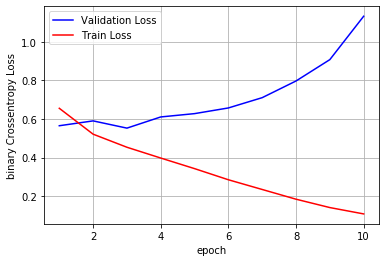

In [59]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))
# x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### Tokenizing the data of the test set

In [63]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

## Load and evaluate the model on test set

In [64]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 44us/step


[1.9176705336380004, 0.54296]